<mark>MIN 30GB MEMORY NEEDED </mark>

in the current implementation this notebook needs roughly 27GB memory to load the 22GB initial conditions files</mark>

# Adjusting pressure in the boundary conditions

## The problem: low pressure boundaries

After model startup, pressure decreases rapidly over the domain. The initial field is ok, but low density air is flooded in from the boundaries. 


In [1]:
# import os
# import sys
# module_path = '/home/m/m300872/warm_eurec4a/submodules/'
# if not module_path in sys.path: sys.path.append(module_path)

# import xarray as xr
# import numpy as np
# import pandas as pd
# import postprocessing as pp

# import matplotlib.pylab as plt
# import datashader
# from datashader.mpl_ext import dsshow

# import cartopy.crs as ccrs
# import cartopy.feature as cf

# def get_data(var, path='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic', include_borders=False):
#     if var in ['sou_t','sob_t','sod_t','thb_t']:
#         [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
#         data = pp.open_mfdataset_with_timedoubles(files)
#         data = pp.clean_surface_data(data, drop_dims=False)
#     else:
#         files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
#         data = pp.open_mfdataset_with_timedoubles(files)
#         data = pp.clean_surface_data(data)
#     data = pp.add_grid(data)
#     if not include_borders: data = pp.cut_borders(data)
#     return data[var]

# def get_projection():
#     central_longitude, central_latitude = 0,0
#     satellite_height = 184759000
#     return ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height)
    
# def ax_map_plot(ax, var, timestep=False, include_borders=True, cmap='viridis', vminmax=(95000,102000)):
#     data = get_data(var, include_borders=include_borders)
#     grid = data 

#     if not timestep: timestep=len(data.time.values)-1
#     variable = data.isel(time=timestep)
    
#     projection = get_projection()
#     coords = projection.transform_points(
#         ccrs.Geodetic(),
#         np.rad2deg(grid.lon),
#         np.rad2deg(grid.lat),)
#     ax.add_feature(cf.COASTLINE, linewidth=0.8)

#     vmin,vmax = vminmax
#     artist = dsshow(
#         pd.DataFrame({
#             "val": variable.values,
#             "x": coords[:, 0],
#             "y": coords[:, 1],}),
#         datashader.Point('x', 'y'),
#         datashader.mean('val'),
#         vmin=vmin, vmax=vmax,
#         cmap=cmap, ax=ax,)
#     ax.set_title(f'{pd.to_datetime(data.time.values[timestep])}')
#     return ax

# fig, axs = plt.subplots(1,3, figsize=(12,4), subplot_kw={"projection": get_projection()})
# fig.canvas.draw_idle()
# var = 'pres_sfc'; cmap='Blues'
# ax = ax_map_plot(axs[0], var, timestep=1,  cmap=cmap)
# ax = ax_map_plot(axs[1], var, timestep=10, cmap=cmap)
# ax = ax_map_plot(axs[2], var, timestep=80, cmap=cmap)
# fig.suptitle('Snapshots of surface pressure development over run time', fontsize=16)
# fig.show()

ICON seems to read the prognostic variables `theta_v` and `rho` for its initial field, while it reads the diagnostic counterparts `p` and `t` for the boundary conditions. I thought I could neglect adjusting pressure at the boundaries, because the temperature perturbation I impose is uniform. As I had to provide `theta_v` and `rho` for the initial field I was forced to recalculate it there. (More plots of the low pressure run can be found [here](https://pad.gwdg.de/1TL7-VEpRiuyUEWQpzm8_w?view))

In [2]:
# import plot_utils as pu

# def fig_pressure_timeseries():
#     fig, ax = plt.subplots(figsize=(5,3))
#     ctrl = xr.open_dataset('../00_preliminary/data/eurecasurface_20230628.nc')
#     warm = xr.open_dataset('../00_preliminary/data/moistadabatic_20230628.nc')
#     ax.plot(warm['pres_sfc'].time, warm[var]/100, label='warming', color='red')
#     ax.plot(ctrl['pres_sfc'].time, ctrl[var]/100, label='control', color='blue')

#     ax = pu.rotate_xticks(ax)
#     ax = pu.remove_spines(ax)
#     ax.set_xlabel('time')
#     ax.set_ylabel('pressure / hPa')
#     ax.legend()
#     ax.set_title(f'surface pressure, domain mean timeseries')
#     fig.tight_layout()
#     return fig, ax

# fig, ax = fig_pressure_timeseries()
# fig.show()

The initial field seems to be OK (reads `rho` and `theta_v`), while after a few hours the lateral boundary conditions dominate. They seem to be off by around 20 hPa (`p` and `t` are read here).

## A look at the boundary conditions

mean vertical profiles: unchanged and moist_adiabatic, initcon and latbc, p,t,rho,theta_v,qv

In [3]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
module_path = '/Users/admin/warm_eurec4a/submodules'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import postprocessing as pp
import calculations as cc

def print_filesize_summary(paths = [
        '/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
        '/work/mh1126/m300872/moist_adiabatic/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
        '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc',
        '/work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc']):
    summe = 0
    for path in paths:
        file_size = os.path.getsize(path) / 1e6
        summe += file_size
        print(int(file_size), 'MB')
    print(f'sum = {int(summe)} MB')

def Mintake_bcprofiles():
    print('this takes approximately 5 minutes')
    data = fh.MinIntake()
    data.ctrl = fh.MinIntake()
    data.warm = fh.MinIntake()
    path = '/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
    data.ctrl.initcon = xr.open_dataset(path).isel(time=0).mean(dim=['ncells', 'ncells_2'])
    data.ctrl.initcon = cc.add_full_level_height(data.ctrl.initcon, varnames={'pressure' : 'p'})
    path = '/work/mh1126/m300872/moist_adiabatic/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
    data.warm.initcon = xr.open_dataset(path).isel(time=0).mean(dim=['ncells', 'ncells_2'])
    data.warm.initcon = cc.add_full_level_height(data.warm.initcon, varnames={'pressure' : 'p'})
    path = '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc'
    data.ctrl.latbc = xr.open_dataset(path).isel(time=0).mean(dim='ncells')
    data.ctrl.latbc = cc.add_full_level_height(data.ctrl.latbc, varnames={'pressure' : 'pres'})
    data.ctrl.latbc = cc.add_prognostic_variables(data.ctrl.latbc)
    path = '/work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc'
    data.warm.latbc = xr.open_dataset(path).isel(time=0).mean(dim='ncells')
    data.warm.latbc = cc.add_full_level_height(data.warm.latbc, varnames={'pressure' : 'pres'})
    data.warm.latbc = cc.add_prognostic_variables(data.warm.latbc)
    print('done')
    return data

def save_mintake(data):
    paths = ['data/profile_ctrl_latbc.nc', 'data/profile_warm_latbc.nc', 
             'data/profile_ctrl_initcon.nc', 'data/profile_warm_initcon.nc']
    datasets = [data.ctrl.latbc, data.warm.latbc, data.ctrl.initcon, data.warm.initcon]
    for p,d in zip(paths, datasets):
        try:
            d.to_netcdf(p)
        except: 
            os.remove(p)
            d.to_netcdf(p)
    
def load_mintake():
    data = fh.MinIntake()
    data.ctrl = fh.MinIntake()
    data.warm = fh.MinIntake()
    data.ctrl.latbc = xr.open_dataset('data/profile_ctrl_latbc.nc')
    data.warm.latbc = xr.open_dataset('data/profile_warm_latbc.nc')
    data.ctrl.initcon = xr.open_dataset('data/profile_ctrl_initcon.nc')
    data.warm.initcon = xr.open_dataset('data/profile_warm_initcon.nc')
    return data

# # commented out because it takes approximately 5 minutes
# data = Mintake_bcprofiles()
# save_mintake(data)

data = load_mintake()

/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


import of konrad failed. the function `joined_profile` will not be usable.


/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/libffi.7.dylib
  Referenced from: <989C6C44-B071-33F3-9244-812DEC674DCA> /opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so
  Reason: tried: '/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/libffi.7.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/libffi.7.dylib' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/libffi.7.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_lab/lib/libffi.7.dylib' (no such file), '/opt/homebrew/Caskroom/mini

Making sure the files are not too big:

In [4]:
import os
profiles = [os.path.join('data',f) for f in os.listdir('data') if f.startswith('profile_')]
print('profile file sizes:')
for p in profiles: print(f'{p.ljust(30)}: {os.path.getsize(p)/1e3:.0f} KB')

profile file sizes:
data/profile_warm_initcon.nc  : 53 KB
data/profile_ctrl_initcon.nc  : 51 KB
data/profile_warm_latbc.nc    : 36 KB
data/profile_ctrl_latbc.nc    : 35 KB


surface pressure:
  ctrl.initcon    1015.2351
  warm.initcon    1015.2351
  ctrl.latbc      1015.7184
  warm.latbc      1015.7184
surface temperature:
  ctrl.initcon    298.82706
  warm.initcon    302.82703
  ctrl.latbc      299.1157
  warm.latbc      303.1157
surface virtual potential temperature:
  ctrl.initcon    300.2351
  warm.initcon    304.9916332745015
  ctrl.latbc      300.61917
  warm.latbc      305.4116994199305
surface density:
  ctrl.initcon    1.1729784
  warm.initcon    1.1546581579547406
  ctrl.latbc      1.1718382
  warm.latbc      1.1534496721140401


/var/folders/0k/t6dd90sx62z4gfqnklc1kkpw0000gp/T/ipykernel_80075/2916139459.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


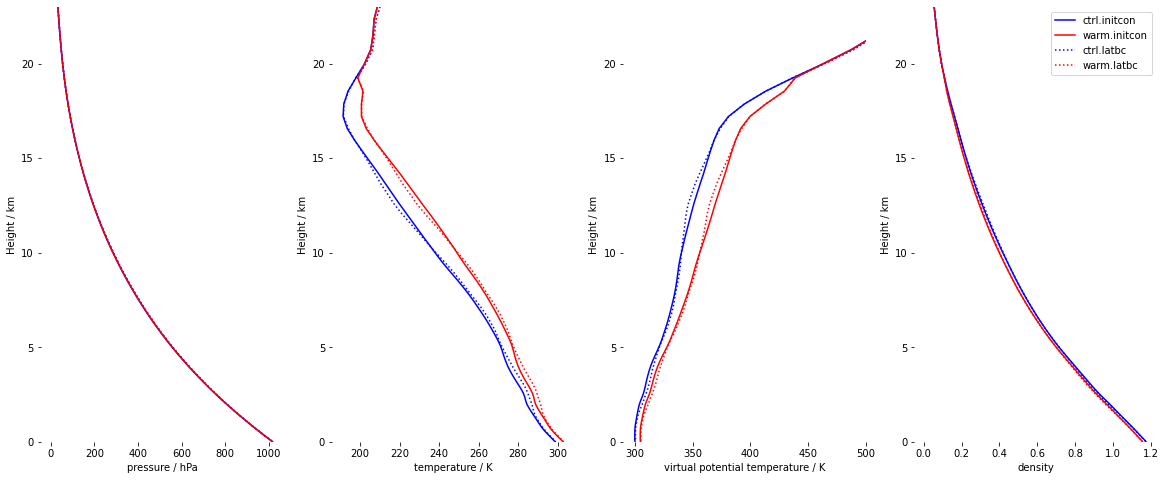

In [5]:
import matplotlib.pyplot as plt
import plot_utils as pu

def fig_profiles(data, verbose=False):
    figsize=(20,8)
    fig, axs = plt.subplots(1,4, figsize=figsize)

    y = data.ctrl.initcon['z'].values / 1000
    kwargs=[{'color' : 'blue'},
            {'color' : 'red'},
            {'color' : 'blue', 'ls' : ':'},
            {'color' : 'red', 'ls' : ':'},]
    labels = ['ctrl.initcon', 'warm.initcon', 'ctrl.latbc', 'warm.latbc']

    ax = axs[0]
    arrays = [data.ctrl.initcon['p'].values / 100, 
              data.warm.initcon['p'].values / 100,
              data.ctrl.latbc['pres'].values / 100,
              data.warm.latbc['pres'].values / 100]
    if verbose: 
        print('surface pressure:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    for x, kw in zip(arrays, kwargs):
        ax.plot(x,y,**kw)
    ax.set_xlabel('pressure / hPa')

    ax = axs[1]
    arrays = [data.ctrl.initcon['t'].values, 
              data.warm.initcon['t'].values,
              data.ctrl.latbc['temp'].values,
              data.warm.latbc['temp'].values]
    if verbose: 
        print('surface temperature:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    for x, kw in zip(arrays, kwargs):
        ax.plot(x,y,**kw)
    ax.set_xlabel('temperature / K')

    ax = axs[2]
    arrays = [data.ctrl.initcon['theta_v'].values, 
              data.warm.initcon['theta_v'].values,
              data.ctrl.latbc['theta_v'].values,
              data.warm.latbc['theta_v'].values]
    if verbose: 
        print('surface virtual potential temperature:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    for x, kw in zip(arrays, kwargs):
        ax.plot(x,y,**kw)
    ax.set_xlabel('virtual potential temperature / K')
    ax.set_xlim([290,500])

    ax = axs[3]
    arrays = [data.ctrl.initcon['rho'].values, 
              data.warm.initcon['rho'].values,
              data.ctrl.latbc['rho'].values,
              data.warm.latbc['rho'].values]
    if verbose: 
        print('surface density:')
        for x,l in zip(arrays,labels): print(' ',l.ljust(15), x[-1])
    for x, kw, label in zip(arrays, kwargs, labels):
        ax.plot(x,y,**kw, label=label)
    ax.set_xlabel('virtual potential temperature / K')
    ax.set_xlabel('density')
    ax.legend()

    for ax in axs: 
        pu.remove_spines(ax)
        ax.set_ylabel('Height / km')
        ax.set_ylim([0,23])
    return fig, axs
    
fig, axs = fig_profiles(data, verbose=True)
fig.show()

pressure is a little lower in the warmed boundary conditions. But it is not as low as it gets during the run (around 995 hPa).

Pressure is more or less the same for both the initial conditions and the lateral boundary conditions. Since it was not changed it is also the the same for control and warming. 

**Does this make sense?** IDK


barometric equation: 
$$ \frac{d P }{dz} = - \rho g $$

but pressure is also in the definition of densisty:

$$ \rho = \frac{\epsilon p\,(1+w)}{R_dT\,(w+\epsilon)} $$

so substituting for yields:

$$ \frac{d P }{dz} = - \frac{\epsilon p\,(1+w)}{R_dT\,(w+\epsilon)} g $$

$$  = p \cdot - \frac{\epsilon (1+w) g }{R_dT\,(w+\epsilon)}$$

In a form suitable for numeric solution:
 
$$ \frac{p_{l+1} - p_l}{h_{l+1} - h_l} = p_l \cdot - \frac{\epsilon (1+w) g }{R_d T_{l+1} \,(w+\epsilon)}$$

$$ \frac{p_{l+1} - p_l}{p_l} = - \frac{\epsilon (1+w) g (h_{l+1} - h_l)}{R_d T_{l+1} \,(w+\epsilon)} $$

$$p_{l+1} = - \frac{p_l \epsilon (1+w) g (h_{l+1} - h_l)}{R_d T_{l+1} \,(w+\epsilon)} + p_l$$ 

with:
 * $R_d$ : Gas constant for dry air at the surface of the Earth
 * $\epsilon$ : molecular weight ratio, the ratio of the molecular weight of the constituent gas to that assumed for air. 
 * $g$ : Avg. gravity acceleration on Earth
 * $w$ : mixing ratio $= \frac{q}{1-q}$, with q being $ = qv_{l+1}$ in our case
 * $q$ : specific humidity
 
as a function:

$$p(h, T, qv, p_{ref}, h_{ref}) = p_{ref} - \frac{p_{ref} \epsilon (1 + \frac{qv}{1-qv}) g (h - h_{ref})}{R_d T \,(\frac{qv}{1-qv} + \epsilon)} $$

As a reference level we can use a level, that is not affected by the moist adiabatic warming. These are the high levels, either selected by height or by the actual temperature change.

In [6]:
def find_reference_level_by_height(height, threshold=20000):
    '''reference level at a specific height'''
    x = height.where(height > threshold).values
    x = x[~np.isnan(x)]
    return len(x) - 1

def find_reference_level_by_temperature(warm_temperature, ctrl_temperature):
    '''reference level as the lowest level not changed by the warming perturbation'''
    x = warm_temperature.where(warm_temperature == ctrl_temperature).values
    x = x[~np.isnan(x)]
    return len(x) - 1

find_reference_level_by_temperature(data.warm.latbc.temp, data.ctrl.latbc.temp), find_reference_level_by_height(data.ctrl.latbc.z)

(13, 12)

In [7]:
import metpy.calc as mpcalc
import metpy.constants as mpconst
from   metpy.units import units

def mixing_ratio(qv):
    return qv / (1 - qv)

def pressure_after_temperature_change(t, qv, h, p_ref, h_ref):
    '''
    $p(h, T, qv, p_{ref}, h_{ref}) = p_{ref} - \frac{p_{ref} \epsilon (1 + \frac{qv}{1-qv}) g (h - h_{ref})}{R_d T \,(\frac{qv}{1-qv} + \epsilon)} $

    with:
     * $R_d$ : Gas constant for dry air at the surface of the Earth
     * $\epsilon$ : molecular weight ratio, the ratio of the molecular weight of the constituent gas to that assumed for air. 
     * $g$ : Avg. gravity acceleration on Earth
     * $w$ : mixing ratio $= \frac{q}{1-q}$, with q being $ = qv_{l+1}$ in our case
     * $q$ : specific humidity
    '''
    eps   = mpconst.molecular_weight_ratio
    Rd    = mpconst.dry_air_gas_constant
    g     = mpconst.earth_gravity
    t     = t * units('kelvin')
    qv    = qv # dimensionless
    h     = h * units('meter')
    p_ref = p_ref * units('pascal')
    h_ref = h_ref * units('meter')
    
    upper = p_ref * eps * (1 + mixing_ratio(qv)) * g * (h - h_ref)
    lower = Rd * t * (mixing_ratio(qv) + eps)
    return p_ref - upper / lower

def calculate_pressure(data, reference_level, varnames):
    # above the reference level, the new vector is a copy of the old one
    p_new = list(data[varnames['pressure']][0:reference_level].values)
    for level in range(reference_level, len(data[varnames['pressure']].values)):
        p = pressure_after_temperature_change(
                 data[varnames['temperature']].values[level], 
                 data[varnames['specific humidity']].values[level], 
                 data[varnames['height']].values[level], 
                 data[varnames['pressure']].values[reference_level], 
                 data[varnames['height']].values[reference_level])
        p_new.append(p.magnitude)
        reference_level = level # MOVE REFERENCE LEVEL
    return p_new

def recalculate_pressure(data, reference_level, varnames):
    data[varnames['pressure']].values = calculate_pressure(data, reference_level, varnames=varnames)
    return data

def ax_recalculated_pressure(ax, data, varnames): 
    p_old_name = 'original'
    data[p_old_name] = data[varnames['pressure']] * 1
    reference_level = find_reference_level_by_height(d[varnames['height']])
    data = recalculate_pressure(data, reference_level, varnames=varnames)

    # ax.set_title('comparison recalculated pressure')
    for v, label in zip([p_old_name, varnames['pressure']], [p_old_name, 'recalculated']):
        x = data[v].values / 100
        y = data['z'].values / 1000
        ax.plot(x,y, label=f'{label}\n{data[v].values[-1]:.0f} Pa at surface')
    ax.set_xlim(0,1100) 
    ax.set_ylim(0,35)
    ax.set_xlabel('pressure / hPa')
    ax.set_ylabel('height / km')
    ax.legend()
    return ax

fig, axs = plt.subplots(1,4, figsize=(16,8))

for ax, d, varnames, title in zip(axs, [data.ctrl.latbc, data.ctrl.initcon, data.warm.latbc, data.warm.initcon],
                           [{'pressure':'pres', 'height':'z', 'temperature':'temp', 'specific humidity':'qv'},
                            {'pressure':'p', 'height':'z', 'temperature':'t', 'specific humidity':'qv'},
                            {'pressure':'pres', 'height':'z', 'temperature':'temp', 'specific humidity':'qv'},
                            {'pressure':'p', 'height':'z', 'temperature':'t', 'specific humidity':'qv'}],
                            ['data.ctrl.latbc', 'data.ctrl.initcon', 'data.warm.latbc', 'data.warm.initcon']):
    ax = ax_recalculated_pressure(ax, d, varnames)
    ax.set_title(title)

fig.show()

/var/folders/0k/t6dd90sx62z4gfqnklc1kkpw0000gp/T/ipykernel_80075/2232243680.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


the recalculation does seem to work, but it does not seem to make a big difference. pressure is around 15 Pa lower for the recalculated values in warmed conditions.

In [8]:
# data = load_mintake()
# varnames = {'pressure':'pres', 'height':'z', 'temperature':'temp', 'specific humidity':'qv'}
# reference_level = find_reference_level_by_height(data_recalc.warm.latbc[varnames['height']])
# data.warm.latbc = recalculate_pressure(data.warm.latbc, reference_level, varnames=varnames)
# varnames = {'pressure':'p', 'height':'z', 'temperature':'t', 'specific humidity':'qv'}
# data.warm.initcon = recalculate_pressure(data.warm.initcon, reference_level, varnames=varnames)

# fig, axs = fig_profiles(data)
# varnames = {'pressure':'pres', 'height':'z', 'temperature':'temp', 'specific humidity':'qv'}
# x = np.asarray(calculate_pressure(data.warm.latbc, reference_level, varnames)) / 100
# y = data.warm.latbc[varnames['height']] / 1000
# axs[0].plot(x,y, color='tab:orange')

# varnames = {'pressure':'p', 'height':'z', 'temperature':'t', 'specific humidity':'qv'}
# x = np.asarray(calculate_pressure(data.warm.initcon, refedrence_level, varnames)) / 100
# y = data.warm.latbc[varnames['height']] / 1000
# axs[0].plot(x,y, color='tab:green')

# fig.show()

## A look into the vertical

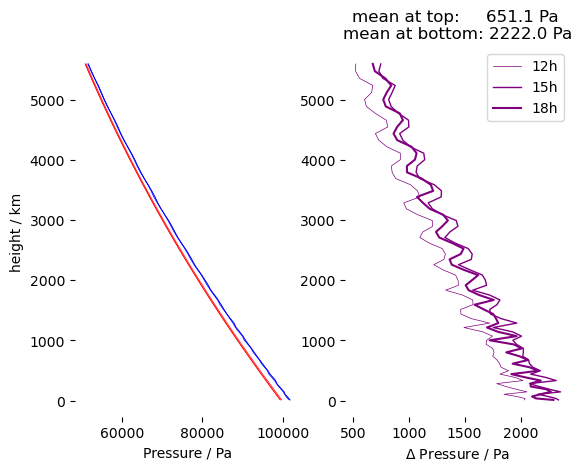

In [24]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import xarray as xr
import numpy as np
import pandas as pd
import postprocessing as pp
import eurec4a
import matplotlib.pyplot as plt
import calculations as cc
import plot_utils as pu

def get_data(var, path='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic'):
    files = [os.path.join(path,f) for f in os.listdir(path) if '3D' in f]
    files = [f for f in files if not 'pl' in f]
    # for f in files: print(f)
    data = xr.open_mfdataset(files)
    data = pp.clean_volume_data(data)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    data = data.mean(dim='cell', keep_attrs=True)
    return data[var]

def get_ctrl(var, timesteps, path='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic'):
    cat = eurec4a.get_intake_catalog()
    data = cat['simulations']['ICON']['LES_CampaignDomain_highCCN']['3D_DOM01'].to_dask()
    data = data.sel(time=timesteps)
    data = pp.add_grid(data)
    data = pp.cut_borders(data)
    attrs = data[var].attrs
    data = data.mean(dim='cell', keep_attrs=True)
    return data[var]

def fig_pressure_profile_comparison(var='pres'):
    warm = get_data(var)
    ctrl = get_ctrl(var, warm.time.values)
    diff = warm - ctrl
    
    cat = eurec4a.get_intake_catalog()
    data = cat['simulations']['ICON']['LES_CampaignDomain_highCCN']['3D_DOM01'].to_dask()
    data = pp.add_grid(data)
    
    y = cc.get_z_full()
    h = data['height'].values.astype(int) - 1
    y = y[h]
    
    fig, axs =  plt.subplots(1,2)
    lw = .5
    ax = axs[0]
    for ti in [0,1,2]:
        x = ctrl.isel(time=ti).values # / 100
        ax.plot(x,y, color='blue', lw=lw)
        x = warm.isel(time=ti).values #/ 100
        ax.plot(x,y, color='red', lw=lw)
    ax = pu.remove_spines(ax)
    ax.set_ylabel('height / km')
    ax.set_xlabel(f'{ctrl.attrs["long_name"]} / {ctrl.attrs["units"]}')

    ax = axs[1]
    for ti in [0,1,2]:
        x = np.abs(diff.isel(time=ti).values) # / 100)
        ax.plot(x,y, color='purple', lw=lw*(ti+1), label=f'{pd.to_datetime(diff.isel(time=ti).time.values).hour}h')
    ax.legend()
    ax.set_xlabel(f'$\Delta$ {ctrl.attrs["long_name"]} / {ctrl.attrs["units"]}')
    ax = pu.remove_spines(ax)

    d = diff.mean(dim='time')
    ax.set_title(f'mean at top:     {np.abs(d.values[0]):.1f} {ctrl.attrs["units"]} \nmean at bottom: {np.abs(d.values[-1]):.1f} {ctrl.attrs["units"]}')
    
    return fig, axs

fig, axs = fig_pressure_profile_comparison()
fig.show()